# **Set Up**

  We'll be using the Kaggle dataset API to download our images and Google Drive to store them, so the first several lines are just a bit of maintenance and prep work do that. We performed our work in Google Colab, as it offers hosted GPUs that make CNN training much, much faster, and some of that prep work is also contained in the first few lines.

In [8]:
! pip install -q kaggle

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mcn9284","key":"86a8a5f625a901c2d5e685a9c20c777f"}'}

In [10]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:13<00:00, 167MB/s]
100% 2.29G/2.29G [00:13<00:00, 178MB/s]


In [13]:
! unzip chest-xray-pneumonia.zip && rm chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [4]:
# Importing necessary libraries
from IPython.core.interactiveshell import InteractiveShell
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomContrast, RandomBrightness, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

InteractiveShell.ast_node_interactivity = 'all'

In [14]:
# Mounting Google Drive
drive.mount('gdrive', force_remount=True)

Mounted at gdrive


# **Data Understanding**


  Our data is stored in directory "chest x_ray" and is further subdivided into three subdirectories--train, val, and test. Each of those is further divided into 'NORMAL' and 'PNEUMONIA' folders. The data itself consists of jpeg images of X-Rays from both patients with and without pneumonia.

  Generally speaking, pneumonia presents on radiograph as areas of diffuse opacity (sometimes called 'ground glass opacity') which represents areas of fluid accumulation in and around the alveoli. This fluid is created by the immune system in an attempt to rid the body of the bacterial or viral invader, and has the unfortunate side-effect of lowering the lungs' ability to exchange oxygen and carbon dioxide. Needless to say, not a good thing.

  Our task is to create a convoluted neural network that can read these radiographs and classify them into either 'normal' or 'pneumonia' categories.

# **Preprocessing**

  We will first create paths to each folder of images, and create our data using generators from those directories. 
  We then associate the labels and images and collapse them into two variables (X for images, y for labels) so we can create a better proportioned train-test-split.

In [15]:
# Path to data
from pathlib import Path
data_dir = Path('chest_xray/')


# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [16]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir,
    batch_size=5216)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    batch_size=624)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    batch_size=16)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [17]:
train_img, train_labels = next(train_generator)
test_img, test_labels = next(test_generator)
val_img, val_labels = next(val_generator)

In [18]:
tr_y = np.reshape(train_labels[:,0], (5216,1))
te_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [19]:
X = np.concatenate((train_img, test_img, val_img))
y = np.concatenate((tr_y, te_y, val_y))

Let's get a sense of what we're working with. First we will visualize our class balance, then we will take a look at several images from each class.

Since we've got a bit of an imbalance here, we will work out the class weights, assign them appropriately, and include them in our parameters later on when we configure our neural networks.

<BarContainer object of 2 artists>

Text(0, 0.5, '# Xray Images')

([0, 1], <a list of 2 Text major ticklabel objects>)

Pneumonia:  4273
Normal:  1583


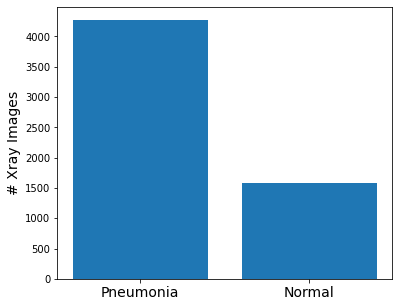

In [20]:
counts = np.unique(y, return_counts=True)[1]
fig, ax = plt.subplots(figsize=(6, 5))
plt.bar(['Pneumonia', 'Normal'], counts)
plt.ylabel('# Xray Images', fontsize=14)
plt.xticks(fontsize=14)
print("Pneumonia: ", counts[0])
print("Normal: ", counts[1])

In [21]:
def class_weights(n, nj):
    return n / (2 * nj)

In [22]:
class_weights(5856, 4273)
print()
class_weights(5856, 1583)

0.6852328574771823

1.8496525584333543

In [23]:
pneumonia_weights = print(
    'weight class 1: ', round(class_weights(5856, 4273), 2))
normal_weights = print('weight class 0: ', round(class_weights(5856, 1583), 2))

weight class 1:  0.69
weight class 0:  1.85


In [24]:
class_weight = {0:0.69, 1:1.85}

Now lets have a look at some of the xrays.

First we'll put the images and their associated labels into a Dataframe, and from there select five randomly from each class



In [25]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# List all normal and pneumonia images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# Create empty list
train_data = []

# Label normal images 0
for img in normal_cases:
    train_data.append((img, 0))

# Label pneumonia images 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Create dataframe with image and label data
train_data = pd.DataFrame(train_data, columns=['image', 'label'], index=None)

# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Inspect dataframe
train_data.head()

,image,label
0,chest_xray/train/PNEUMONIA/person712_virus_131...,1
1,chest_xray/train/NORMAL/NORMAL2-IM-1310-0001.jpeg,0
2,chest_xray/train/PNEUMONIA/person704_virus_130...,1
3,chest_xray/train/PNEUMONIA/person266_bacteria_...,1
4,chest_xray/train/PNEUMONIA/person1546_bacteria...,1


Text(0.5, 1.0, 'Pneumonia')

(-0.5, 644.5, 461.5, -0.5)

Text(0.5, 1.0, 'Pneumonia')

(-0.5, 1135.5, 727.5, -0.5)

Text(0.5, 1.0, 'Pneumonia')

(-0.5, 991.5, 671.5, -0.5)

Text(0.5, 1.0, 'Pneumonia')

(-0.5, 1215.5, 855.5, -0.5)

Text(0.5, 1.0, 'Pneumonia')

(-0.5, 1399.5, 1031.5, -0.5)

Text(0.5, 1.0, 'Normal')

(-0.5, 1607.5, 1467.5, -0.5)

Text(0.5, 1.0, 'Normal')

(-0.5, 1483.5, 1398.5, -0.5)

Text(0.5, 1.0, 'Normal')

(-0.5, 1893.5, 1687.5, -0.5)

Text(0.5, 1.0, 'Normal')

(-0.5, 1719.5, 1641.5, -0.5)

Text(0.5, 1.0, 'Normal')

(-0.5, 1785.5, 1436.5, -0.5)

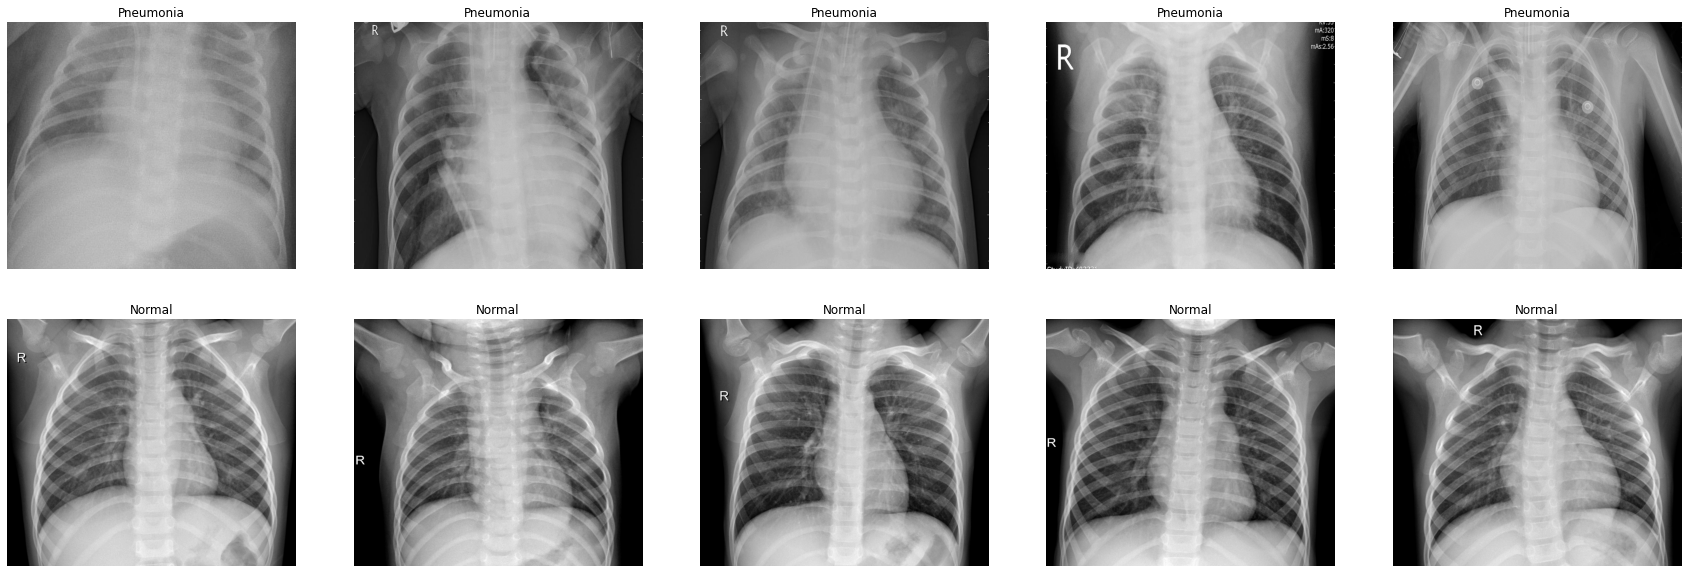

In [26]:
from skimage.io import imread

# Create lists of the first five rows in each class
pneumonia_samples = (
    train_data[train_data['label'] == 1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']
                  == 0]['image'].iloc[:5]).tolist()

# Concatenate and delete the two lists
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot data
f, ax = plt.subplots(2, 5, figsize=(30, 10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i % 5].set_title("Pneumonia")
    else:
        ax[i//5, i % 5].set_title("Normal")
    ax[i//5, i % 5].axis('off')
    ax[i//5, i % 5].set_aspect('auto')
plt.show()

There are definite differences between the two classes visually, with pneumonia xrays showing the characteristic 'ground glass opacity'. There are a few cases that, at least to the untrained eye, appear to be ambiguous. Hopefully our model can pick up on features we can't.

The last step of our preprocessing process is to split our data. Recall just a bit ago that we collapsed all the images and labels into X and y variables without respect to test or validation datasets. The idea was that, since the data had been apportioned so awfully, we'd bypass that dumpster fire and split the data in a way that's easier to work with. 

We use a train_test_split, set the test_size to 20% of the total data, and shuffle!

Then of course we check the shape of our splits.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, shuffle=True, random_state=42)

In [28]:
print('Training Shape: ', X_train.shape)
print("Test Shape: ", X_test.shape)

Training Shape:  (4684, 256, 256, 3)
Test Shape:  (1172, 256, 256, 3)


In [29]:
keras.backend.clear_session()

# **Modeling**

Our baseline model will start with one convolution/pooling layer, flattened into a 32 unit fully connected layer, which feeds into an output layer with sigmoid activation.

Our conv layer has a filter size of 5x5 because we want the network to have a larger receptive field and to pick up on more general features (at least to start!). 

We use an adam optimizer with learning rate set at 0.0001.

## **Model 1**

In [30]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, mode='min',patience=10)

In [31]:
cnn1 = keras.Sequential()

cnn1.add(layers.Conv2D(8, (5, 5), activation='relu', input_shape=(256, 256, 3)))
cnn1.add(layers.MaxPooling2D(2, 2))

cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(32, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=1e-4)
cnn1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [32]:
cnn1.build(input_shape=(None, 256, 256, 3))
cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 8)       608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 8)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 32)                4064288   
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,064,929
Trainable params: 4,064,929
Non-trainable params: 0
______________________________________________

In [33]:
history1 = cnn1.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    class_weight=class_weight,
                    validation_split=0.20,
                    #callbacks=callbacks,
                    verbose=1)

Epoch 1/50
118/118 [==============================] - 12s 22ms/step - loss: 0.4248 - accuracy: 0.8127 - val_loss: 0.2227 - val_accuracy: 0.9264
Epoch 2/50
118/118 [==============================] - 2s 13ms/step - loss: 0.2443 - accuracy: 0.9034 - val_loss: 0.1566 - val_accuracy: 0.9456
Epoch 3/50
118/118 [==============================] - 2s 13ms/step - loss: 0.1934 - accuracy: 0.9279 - val_loss: 0.1591 - val_accuracy: 0.9456
Epoch 4/50
118/118 [==============================] - 2s 13ms/step - loss: 0.1703 - accuracy: 0.9338 - val_loss: 0.1291 - val_accuracy: 0.9530
Epoch 5/50
118/118 [==============================] - 2s 13ms/step - loss: 0.1586 - accuracy: 0.9346 - val_loss: 0.1448 - val_accuracy: 0.9445
Epoch 6/50
118/118 [==============================] - 2s 13ms/step - loss: 0.1696 - accuracy: 0.9343 - val_loss: 0.3270 - val_accuracy: 0.8634
Epoch 7/50
118/118 [==============================] - 2s 13ms/step - loss: 0.1404 - accuracy: 0.9450 - val_loss: 0.1490 - val_accuracy: 0.942

The following two functions allow us to evaluate our models as we progress.

The first plots our train and validation loss and accuracies over epoch.

The second generates a confusion matrix to make up for some of the deficiencies presented by accuracy as a metric.

In [34]:
def learn_curves(history):
   # get history of model
    history_dict = history.history

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # define accruacy and loss values
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    # set x range
    epochs = range(1, len(acc_values) + 1)

    # plot accuracy for training and validation
    ax[0].plot(epochs, acc_values, label='Training acc')
    ax[0].plot(epochs, val_acc_values, label='Validation acc')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # plot loss for training and validation
    ax[1].plot(epochs, loss_values, label='Training loss')
    ax[1].plot(epochs, val_loss_values, label='Validation loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    print("Final Training Accuracy:", acc_values[-1])
    print("Final Validation Accuracy:", val_acc_values[-1])

In [35]:
def evaluation(model):
    predictions = (model.predict(X_test) > 0.5)*1
    cm = confusion_matrix(y_test, predictions)

    df_cm = pd.DataFrame(cm.T, index=['Pneumonia', 'Normal'],
                         columns=['Pneumonia', 'Normal'])
    sns.heatmap(df_cm.T, annot=True, fmt='d', cmap='Blues',
                linecolor='black', linewidths=1)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.ylim(0, 2)
    plt.xlim(2, 0)
    plt.show()

    print(model.evaluate(X_test, y_test))

Final Training Accuracy: 0.9991993308067322
Final Validation Accuracy: 0.9519743919372559


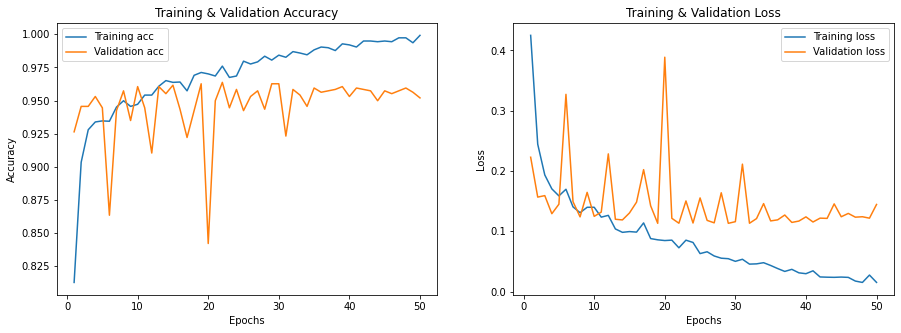

In [36]:
learn_curves(history1)

37/37 [==============================] - 0s 9ms/step


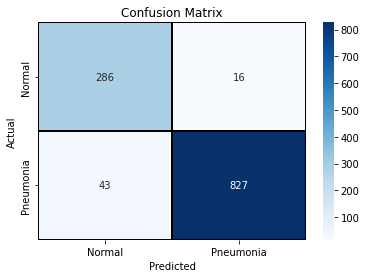

37/37 [==============================] - 0s 9ms/step - loss: 0.1433 - accuracy: 0.9497
[0.14334379136562347, 0.9496586918830872]


In [37]:
evaluation(cnn1)

So, clearly we have some overfitting. We will introduce a regularization term on the conv layer and see if we can get that under some control. 

Overfitting aside, these are encouraging results!

##  **Model 2**

In [38]:
cnn2 = keras.Sequential()

cnn2.add(layers.Conv2D(8, (5, 5), activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(256, 256, 3)))
cnn2.add(layers.MaxPooling2D(2, 2))

cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(32, activation='relu'))
cnn2.add(layers.Dense(units=1, activation='sigmoid'))


opt = keras.optimizers.Adam(learning_rate=4e-4)
cnn2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn2.build(input_shape=(None, 256, 256, 3))
cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 252, 252, 8)       608       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 8)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 127008)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                4064288   
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,064,929
Trainable params: 4,064,929
Non-trainable params: 0
____________________________________________

In [39]:
history2 = cnn2.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    class_weight=class_weight,
                    validation_split=0.20,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50
118/118 [==============================] - 3s 17ms/step - loss: 0.4878 - accuracy: 0.8084 - val_loss: 0.2597 - val_accuracy: 0.9061
Epoch 2/50
118/118 [==============================] - 2s 13ms/step - loss: 0.2427 - accuracy: 0.9239 - val_loss: 0.1862 - val_accuracy: 0.9445
Epoch 3/50
118/118 [==============================] - 2s 13ms/step - loss: 0.2029 - accuracy: 0.9394 - val_loss: 0.1700 - val_accuracy: 0.9509
Epoch 4/50
118/118 [==============================] - 2s 13ms/step - loss: 0.1881 - accuracy: 0.9509 - val_loss: 0.1720 - val_accuracy: 0.9509
Epoch 5/50
118/118 [==============================] - 2s 13ms/step - loss: 0.1585 - accuracy: 0.9570 - val_loss: 0.1591 - val_accuracy: 0.9594
Epoch 6/50
118/118 [==============================] - 2s 13ms/step - loss: 0.1497 - accuracy: 0.9576 - val_loss: 0.1627 - val_accuracy: 0.9584
Epoch 7/50
118/118 [==============================] - 2s 13ms/step - loss: 0.1641 - accuracy: 0.9568 - val_loss: 0.2273 - val_accuracy: 0.9306

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9519743919372559


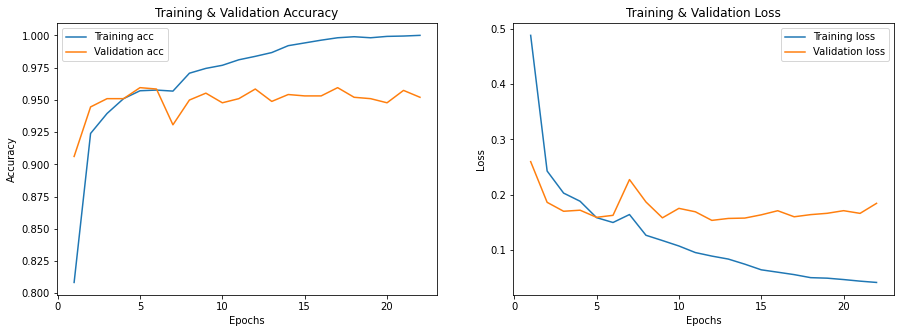

In [40]:
learn_curves(history2)

37/37 [==============================] - 0s 8ms/step


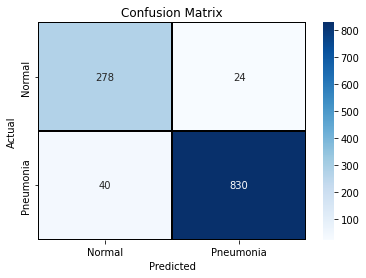

37/37 [==============================] - 0s 9ms/step - loss: 0.1802 - accuracy: 0.9454
[0.18024612963199615, 0.9453924894332886]


In [41]:
evaluation(cnn2)

The l2 regularization helped, but we went a little light in our efforts. 

So we are gonna do a couple of things. First, and this won't help with the fit, we will increase the complexity of the model and lower the learning rate to hopefully speed things up a bit.

We will introduce regularization on each conv block and include a dropout layer just before the classifier. The dropout is set at 0.50.

##  **Model 3**

In [42]:
cnn3 = keras.Sequential()

cnn3.add(layers.Conv2D(8, 5, activation='relu', input_shape=(256, 256, 3)))
cnn3.add(layers.Conv2D(16, 3, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn3.add(layers.MaxPooling2D(2, 2))

cnn3.add(layers.Conv2D(16, 3, activation='relu'))
cnn3.add(layers.Conv2D(32, 3, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn3.add(layers.MaxPooling2D(2, 2))

cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(64, activation='relu'))
cnn3.add(layers.Dropout(0.5))
cnn3.add(layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(1e-5)
cnn3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn3.build(input_shape=(None, 256, 256, 3))
cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 252, 252, 8)       608       
                                                                 
 conv2d_3 (Conv2D)           (None, 250, 250, 16)      1168      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 123, 123, 16)      2320      
                                                                 
 conv2d_5 (Conv2D)           (None, 121, 121, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                  

In [43]:
history3 = cnn3.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.20,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50
118/118 [==============================] - 4s 25ms/step - loss: 0.9940 - accuracy: 0.4521 - val_loss: 0.9703 - val_accuracy: 0.7108
Epoch 2/50
118/118 [==============================] - 2s 21ms/step - loss: 0.8939 - accuracy: 0.7683 - val_loss: 0.8377 - val_accuracy: 0.8463
Epoch 3/50
118/118 [==============================] - 2s 21ms/step - loss: 0.7679 - accuracy: 0.8423 - val_loss: 0.6929 - val_accuracy: 0.8794
Epoch 4/50
118/118 [==============================] - 2s 21ms/step - loss: 0.6763 - accuracy: 0.8610 - val_loss: 0.5958 - val_accuracy: 0.9104
Epoch 5/50
118/118 [==============================] - 2s 21ms/step - loss: 0.6220 - accuracy: 0.8799 - val_loss: 0.5489 - val_accuracy: 0.9221
Epoch 6/50
118/118 [==============================] - 2s 20ms/step - loss: 0.5920 - accuracy: 0.8970 - val_loss: 0.5836 - val_accuracy: 0.8997
Epoch 7/50
118/118 [==============================] - 2s 20ms/step - loss: 0.5531 - accuracy: 0.9085 - val_loss: 0.5210 - val_accuracy: 0.9264

Final Training Accuracy: 0.9586336016654968
Final Validation Accuracy: 0.9573105573654175


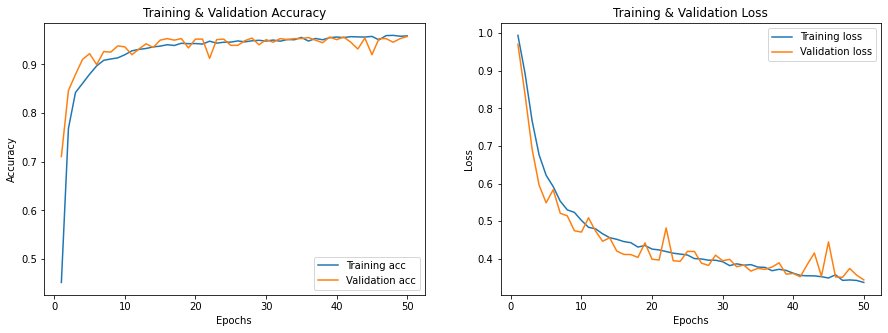

In [44]:
learn_curves(history3)

37/37 [==============================] - 0s 11ms/step


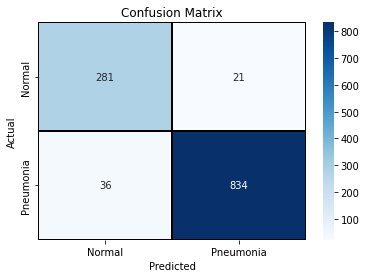

37/37 [==============================] - 0s 11ms/step - loss: 0.3494 - accuracy: 0.9514
[0.3493589758872986, 0.9513651728630066]


In [45]:
evaluation(cnn3)

That is looking a lot better. The fit looks fine now, but the model still seems a bit slow to converge. It's also rather noisy. 

We will increase the complexity again, but limit our regularization to the dense layers, of which there are now two. 

Another good way to keep overfitting in check is to introduce more data. For this we're adding a preprocessing layer that randomly tweaks the image contrast. Given the nature of X-ray imagery, this could be draw out new features or mask unimportant ones.

## **Model 4**

In [46]:
cnn4 = keras.Sequential()

cnn4.add(layers.experimental.preprocessing.RandomContrast([0.2, 0.8]))

cnn4.add(layers.Conv2D(8, (5, 5), activation='relu', input_shape=(256, 256, 3)))
cnn4.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn4.add(layers.MaxPooling2D(2, 2))

cnn4.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn4.add(layers.MaxPooling2D(2, 2))

cnn4.add(layers.Flatten())
cnn4.add(layers.Dense(32, activation='relu'))
cnn4.add(layers.Dropout(0.4))
cnn4.add(layers.Dense(64, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn4.add(layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(1e-5)
cnn4.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn4.build(input_shape=(None, 256, 256, 3))
cnn4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 252, 252, 8)       608       
                                                                 
 conv2d_7 (Conv2D)           (None, 250, 250, 16)      1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 123, 123, 16)      2320      
                                                                 
 conv2d_9 (Conv2D)           (None, 121, 121, 32)     

In [47]:
history4 = cnn4.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.20,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50


118/118 [==============================] - 14s 105ms/step - loss: 1.1035 - accuracy: 0.3672 - val_loss: 1.0854 - val_accuracy: 0.7727
Epoch 2/50
118/118 [==============================] - 12s 101ms/step - loss: 1.0450 - accuracy: 0.6109 - val_loss: 1.0298 - val_accuracy: 0.8218
Epoch 3/50
118/118 [==============================] - 12s 101ms/step - loss: 0.9784 - accuracy: 0.6963 - val_loss: 0.9497 - val_accuracy: 0.9007
Epoch 4/50
118/118 [==============================] - 12s 100ms/step - loss: 0.9150 - accuracy: 0.7489 - val_loss: 0.8667 - val_accuracy: 0.9317
Epoch 5/50
118/118 [==============================] - 12s 101ms/step - loss: 0.8634 - accuracy: 0.7870 - val_loss: 0.8132 - val_accuracy: 0.9328
Epoch 6/50
118/118 [==============================] - 12s 100ms/step - loss: 0.8190 - accuracy: 0.8054 - val_loss: 0.7766 - val_accuracy: 0.9157
Epoch 7/50
118/118 [==============================] - 12s 100ms/step - loss: 0.7848 - accuracy: 0.8257 - val_loss: 0.7245 - val_accuracy: 0.9

Final Training Accuracy: 0.9420869946479797
Final Validation Accuracy: 0.9573105573654175


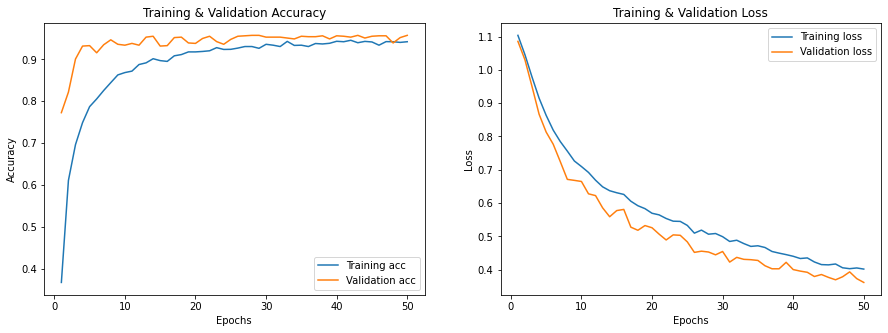

In [48]:
learn_curves(history4)

37/37 [==============================] - 0s 10ms/step


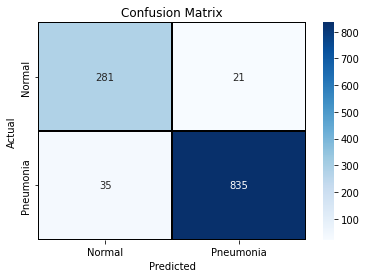

37/37 [==============================] - 0s 11ms/step - loss: 0.3652 - accuracy: 0.9522
[0.3652116656303406, 0.9522184133529663]


In [49]:
evaluation(cnn4)

Now we might have a different issue--underfitting. We'll keep the additional data provided by the preprocessing layer, and increase the complexity.

##  **Model 5**

In [50]:
cnn5 = keras.Sequential()

cnn5.add(layers.experimental.preprocessing.RandomContrast([0.2, 0.8]))

cnn5.add(layers.Conv2D(8, (5, 5), activation='relu', input_shape=(256, 256, 3)))
cnn5.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn5.add(layers.MaxPooling2D(2, 2))

cnn5.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn5.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn5.add(layers.MaxPooling2D(2, 2))

cnn5.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn5.add(layers.Conv2D(64, (3, 3), activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn5.add(layers.MaxPooling2D(2, 2))

cnn5.add(layers.Flatten())
cnn5.add(layers.Dense(128, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn5.add(layers.Dropout(0.5))
cnn5.add(layers.Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(1e-5)
cnn5.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn5.build(input_shape=(None, 256, 256, 3))
cnn5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast_1 (RandomCo  (None, 256, 256, 3)      0         
 ntrast)                                                         
                                                                 
 conv2d_10 (Conv2D)          (None, 252, 252, 8)       608       
                                                                 
 conv2d_11 (Conv2D)          (None, 250, 250, 16)      1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 123, 123, 16)      2320      
                                                                 
 conv2d_13 (Conv2D)          (None, 121, 121, 32)     

In [51]:
history5 = cnn5.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.20,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50


118/118 [==============================] - 15s 111ms/step - loss: 3.5380 - accuracy: 0.4462 - val_loss: 3.2401 - val_accuracy: 0.2679
Epoch 2/50
118/118 [==============================] - 12s 103ms/step - loss: 2.9046 - accuracy: 0.7430 - val_loss: 2.5878 - val_accuracy: 0.9039
Epoch 3/50
118/118 [==============================] - 12s 102ms/step - loss: 2.3587 - accuracy: 0.8244 - val_loss: 2.1020 - val_accuracy: 0.9168
Epoch 4/50
118/118 [==============================] - 12s 103ms/step - loss: 1.9764 - accuracy: 0.8575 - val_loss: 1.7989 - val_accuracy: 0.9061
Epoch 5/50
118/118 [==============================] - 12s 103ms/step - loss: 1.7124 - accuracy: 0.8743 - val_loss: 1.5525 - val_accuracy: 0.9317
Epoch 6/50
118/118 [==============================] - 12s 102ms/step - loss: 1.5256 - accuracy: 0.8900 - val_loss: 1.3995 - val_accuracy: 0.9189
Epoch 7/50
118/118 [==============================] - 12s 103ms/step - loss: 1.3898 - accuracy: 0.8962 - val_loss: 1.3345 - val_accuracy: 0.8

Final Training Accuracy: 0.9484921097755432
Final Validation Accuracy: 0.9477054476737976


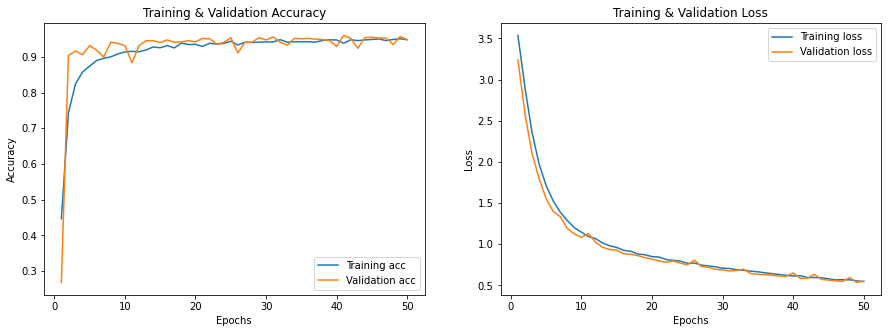

In [52]:
learn_curves(history5)

In [53]:
def evaluation(model):
    predictions = (model.predict(X_test) > 0.5)*1
    cm = confusion_matrix(y_test, predictions)

    df_cm = pd.DataFrame(cm.T, index=['Pneumonia', 'Normal'],
                         columns=['Pneumonia', 'Normal'])
    sns.heatmap(df_cm.T, annot=True, fmt='d', cmap='Blues',
                linecolor='black', linewidths=1)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.ylim(0, 2)
    plt.xlim(2, 0)
    plt.show()

    print(model.evaluate(X_test, y_test))

37/37 [==============================] - 0s 11ms/step


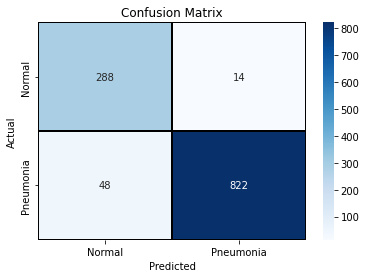

37/37 [==============================] - 0s 11ms/step - loss: 0.5499 - accuracy: 0.9471
[0.5498999357223511, 0.947098970413208]


In [54]:
evaluation(cnn5)

That created a few more false negatives than I'm confortable with. Generally speaking, the balance between bias and variance is going to be situation-dependent. In some instances, having more false positives is preferable to false negatives, such as here.

For medical situations, it's better to treat an illness that isn't there than to miss an illness that actually is there. So we want to minimize our false negatives as much as we can.

##  **Model 6**

In [55]:
cnn6 = keras.Sequential()

cnn6.add(layers.experimental.preprocessing.RandomContrast([0.2, 0.8]))

cnn6.add(layers.Conv2D(8, (5, 5), activation='relu', input_shape=(256, 256, 3)))
cnn6.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn6.add(layers.MaxPooling2D(2, 2))

cnn6.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn6.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn6.add(layers.MaxPooling2D(2, 2))

cnn6.add(layers.Conv2D(64, (3, 3), activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn6.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn6.add(layers.Dropout(0.5))
cnn6.add(layers.MaxPooling2D(2, 2))

cnn6.add(layers.Flatten()),
cnn6.add(layers.Dense(256, activation='relu')),
cnn6.add(layers.Dropout(0.5))
cnn6.add(layers.Dense(1, activation='sigmoid'))


opt = keras.optimizers.Adam(1e-5)
cnn6.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn6.build(input_shape=(None, 256, 256, 3))
cnn6.summary()

(None,)

(None,)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast_2 (RandomCo  (None, 256, 256, 3)      0         
 ntrast)                                                         
                                                                 
 conv2d_16 (Conv2D)          (None, 252, 252, 8)       608       
                                                                 
 conv2d_17 (Conv2D)          (None, 250, 250, 16)      1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 123, 123, 16)      2320      
                                                                 
 conv2d_19 (Conv2D)          (None, 121, 121, 32)     

In [56]:
opt = keras.optimizers.Adam(1e-5)

cnn6.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn6.build(input_shape=(None, 256, 256, 3))
cnn6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_contrast_2 (RandomCo  (None, 256, 256, 3)      0         
 ntrast)                                                         
                                                                 
 conv2d_16 (Conv2D)          (None, 252, 252, 8)       608       
                                                                 
 conv2d_17 (Conv2D)          (None, 250, 250, 16)      1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 123, 123, 16)      2320      
                                                                 
 conv2d_19 (Conv2D)          (None, 121, 121, 32)     

In [57]:
history6 = cnn6.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.20,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50


118/118 [==============================] - 15s 109ms/step - loss: 1.0370 - accuracy: 0.6958 - val_loss: 0.9478 - val_accuracy: 0.8922
Epoch 2/50
118/118 [==============================] - 12s 105ms/step - loss: 0.8064 - accuracy: 0.8527 - val_loss: 0.8332 - val_accuracy: 0.8943
Epoch 3/50
118/118 [==============================] - 12s 104ms/step - loss: 0.7161 - accuracy: 0.8671 - val_loss: 0.7526 - val_accuracy: 0.9285
Epoch 4/50
118/118 [==============================] - 12s 105ms/step - loss: 0.6547 - accuracy: 0.8965 - val_loss: 0.7093 - val_accuracy: 0.9274
Epoch 5/50
118/118 [==============================] - 12s 105ms/step - loss: 0.6122 - accuracy: 0.9122 - val_loss: 0.6649 - val_accuracy: 0.9338
Epoch 6/50
118/118 [==============================] - 12s 105ms/step - loss: 0.5968 - accuracy: 0.9114 - val_loss: 0.6505 - val_accuracy: 0.9370
Epoch 7/50
118/118 [==============================] - 12s 105ms/step - loss: 0.5742 - accuracy: 0.9157 - val_loss: 0.6078 - val_accuracy: 0.9

Final Training Accuracy: 0.9607686400413513
Final Validation Accuracy: 0.9626467227935791


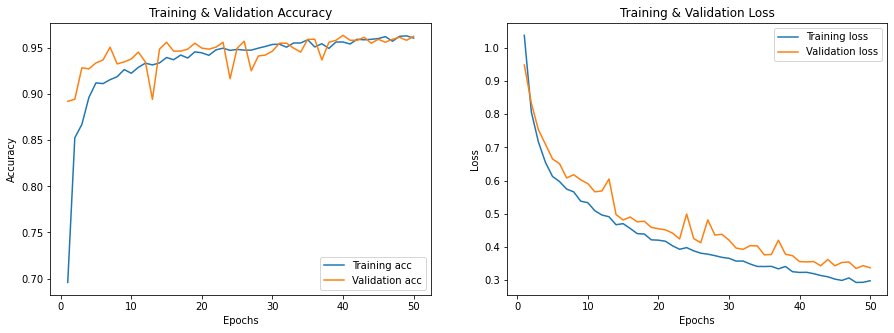

In [58]:
learn_curves(history6)

37/37 [==============================] - 0s 11ms/step


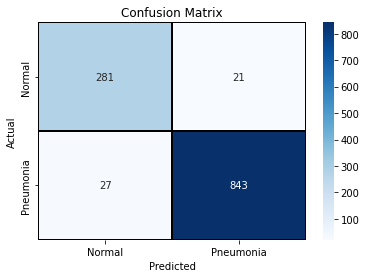

37/37 [==============================] - 0s 12ms/step - loss: 0.3408 - accuracy: 0.9590
[0.3407767713069916, 0.9590443968772888]


In [59]:
evaluation(cnn6)

That didn't quite work as expected. Bias-variance tradeoff strikes again. 

Let's increase both complexity and regularization.

In [ ]:
keras.backend.clear_session()

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', mode='min', patience=10)

## **Model 7**

Here we will increase number of filters in all layers, regularize the final conv layer and both dense layers, and dropout just before and after flatten.

In [ ]:
cnn7 = keras.Sequential()

cnn7.add(layers.experimental.preprocessing.RandomContrast([0.2, 0.8]))

cnn7.add(layers.Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3)))
cnn7.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D(2, 2))

cnn7.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn7.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn7.add(layers.MaxPooling2D(2, 2))

cnn7.add(layers.Conv2D(128, (3, 3), activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn7.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn7.add(layers.Dropout(0.5))
cnn7.add(layers.MaxPooling2D(2, 2))

cnn7.add(layers.Flatten())
cnn7.add(layers.Dense(256, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn7.add(layers.Dense(512, activation='relu',
         kernel_regularizer=keras.regularizers.l2(0.01)))
cnn7.add(layers.Dropout(0.5))
cnn7.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
opt = keras.optimizers.Adam(1e-5)

cnn7.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn7.build(input_shape=(None, 256, 256, 3))
cnn7.summary()

In [ ]:
history7 = cnn7.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.20,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    verbose=1)

In [ ]:
learn_curves(history7)

In [ ]:
evaluation(cnn7)

# **Evaluation**

CNN7, though its validation and test accuracies were not the highest, minimized the number of false negatives and seemed to generalize better than the other models. Using a complex model to pick up as many features as possible, while using regularization to keep weights in check, seems to strike the right balance between generalization and error rate. 

The biggest drawback is the preprocessing layer adding a not-so-insignificant chunk of computation time. Callbacks helped, but min_delta should probably be higher.

The model features two blocks of two stacks of conv2d layers with max pooling, a third such block with the first convolutional layer l2 regularized and dropout on the second at 50%.

All filters are doubled in number from previous iteration, and filter sizes remain the same.

In [ ]:
from keras.models import load_model

cnn7.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del cnn7  # deletes the existing model

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

In [ ]:
final = models.load_model('my_model.h5')

In [ ]:
final.evaluate(X_train, y_train)

In [ ]:
test_pred = final.predict((X_test<=0.49999)*1)
evaluation(final)

In [ ]:
from sklearn.metrics import classification_report
classification_report(y_test, test_pred)

# **Recommendations**

1. Positive cases should be confirmed by trained medical personnel

2. Expand training with wider patient dataset (current Xrays were taken only from pediatric patients)

3. At almost 95% accuracy with 97% recall, the results can be relied upon to flag positive pneumonia cases. 

4. Perfect for urgent care clinics and emergency departments where the potential exists for high volume and necessitates quick turn around.